<a href="https://colab.research.google.com/github/rs-saran/sindy/blob/main/ML_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import lorenz
import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

Simple linear systems


### Linear 2 dymensional ODE


In [50]:
# Generate training data
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [51]:
#finding the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.001}
(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


In [52]:
# Fit the model with best parameters

poly_order = 1
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


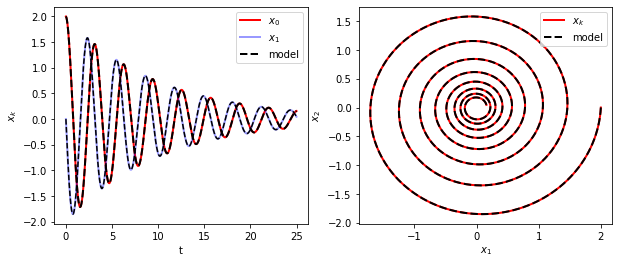

In [53]:
x_sim = model.simulate(x0_train, t_train) 
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Linear 3d ode


In [54]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0, 1]
x_train = solve_ivp(linear_3D, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [55]:
#finding the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/stlsq.py:193: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1
(x2)' = -0.300 x2


In [56]:
# Fit the model with best hyperparameters

poly_order = 1
threshold = 0.01

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()


(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1
(x2)' = -0.300 x2


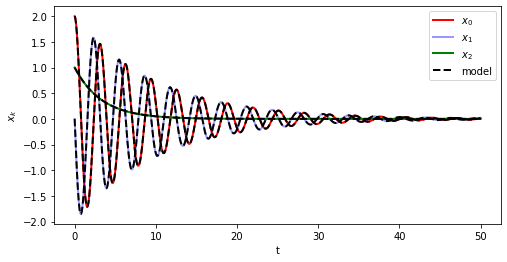

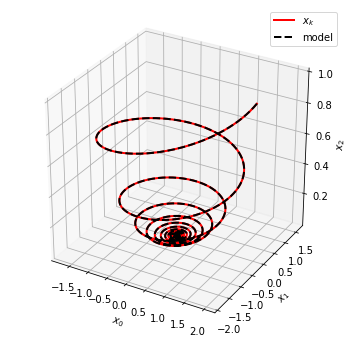

In [57]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(8, 4))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

### Lorenz

In [58]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

In [59]:
#finding the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.001}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [60]:
# Fit the model with best hyperparameters

poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [61]:
# Simulate and plot the results
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

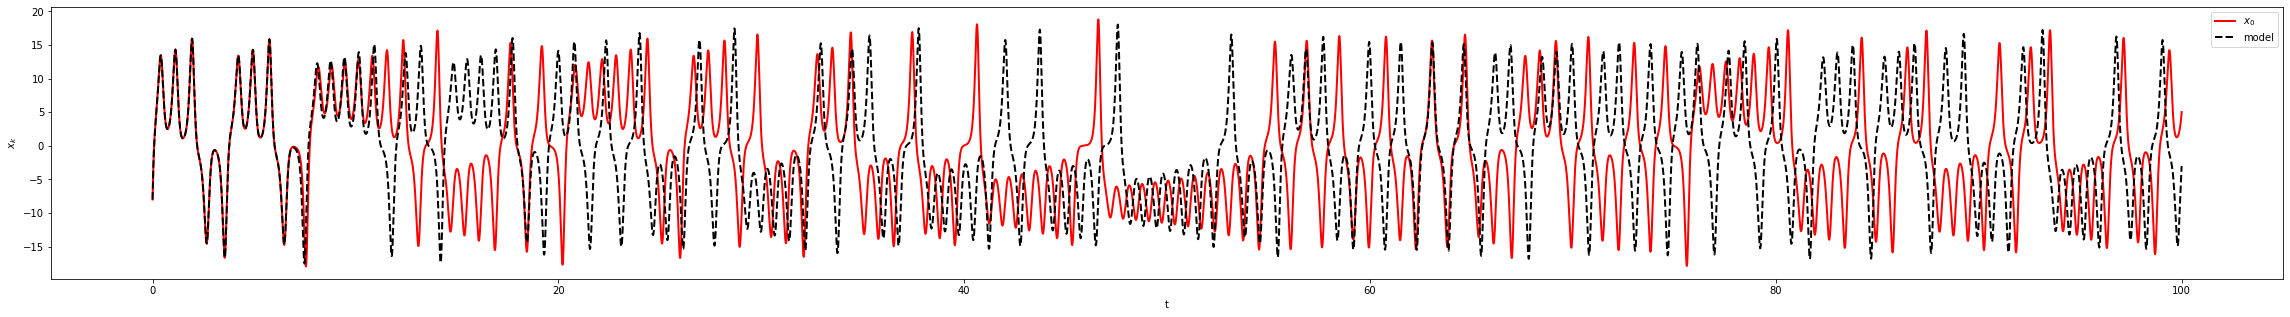

In [62]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

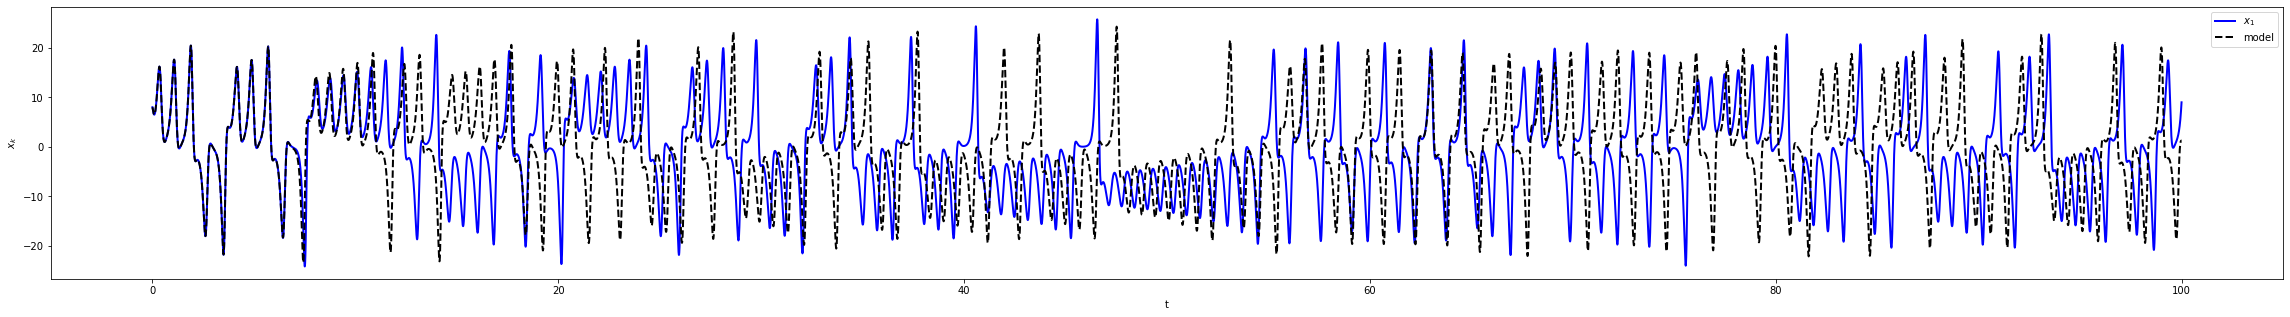

In [63]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

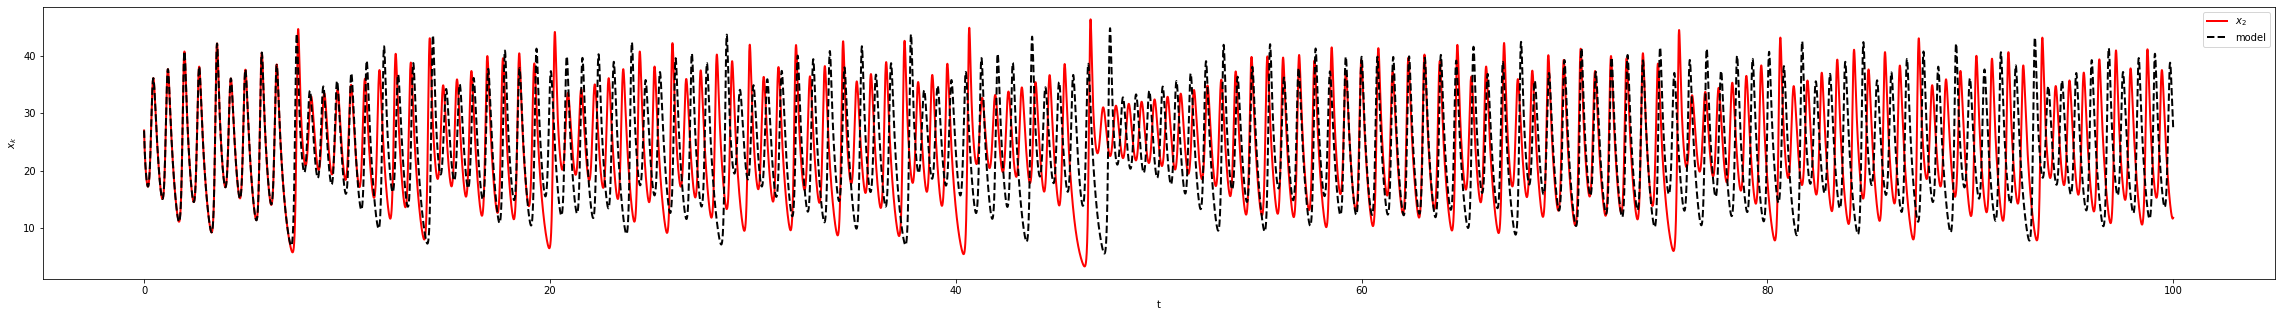

In [64]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 2], "r", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

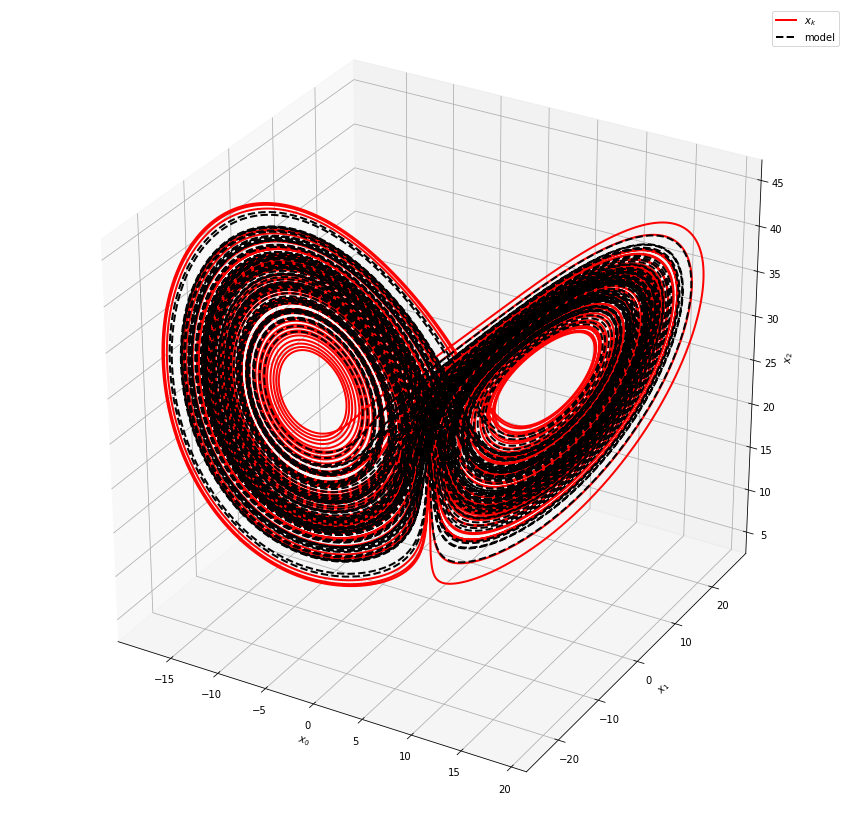

In [65]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

In the Lorenz example, the ability to capture dynamics on the
attractor is more important than the ability to predict an individual
trajectory, because chaos will quickly cause any small variations in
initial conditions or model coefficients to diverge exponentially.
As shown in Fig. 1, the sparse model accurately reproduces the
attractor dynamics from chaotic trajectory measurements. The
algorithm not only identifies the correct terms in the dynamics, but
it accurately determines the coefficients to within .03% of the true
values. We also explore the identification of the dynamics when
only noisy state measurements are available (SI Appendix, Fig. S7).
The correct dynamics are identified, and the attractor is preserved
for surprisingly large noise values. In SI Appendix, section 4.5, we
reconstruct the attractor dynamics in the Lorenz system using
time-delay coordinates from a single measurement xðtÞ

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


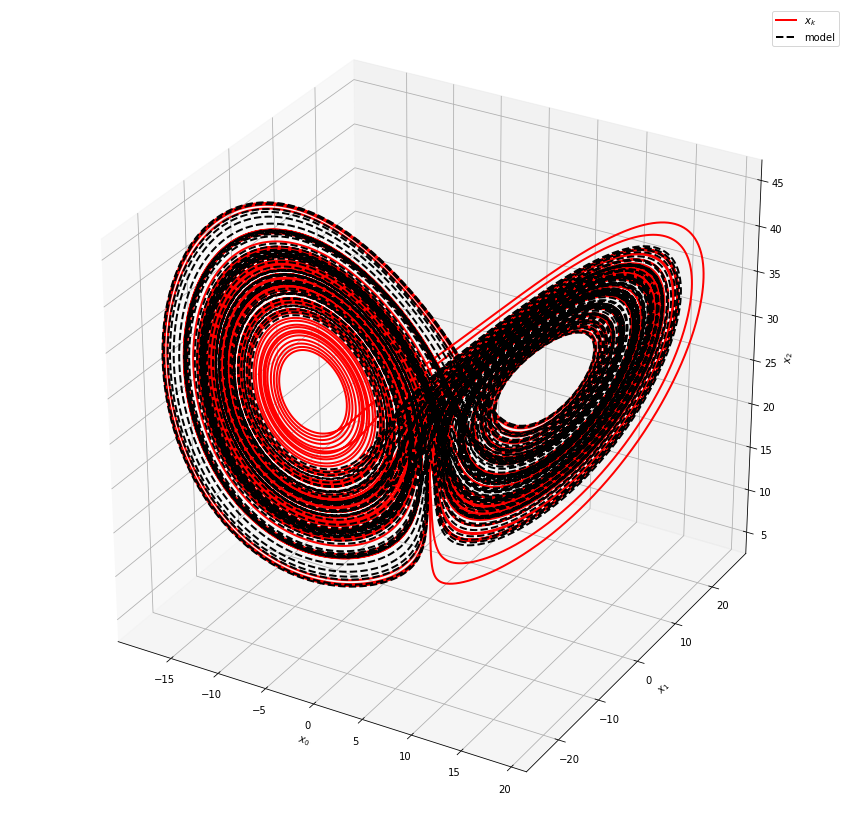

In [66]:
### adding noise on a scale of 1e-4
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-4, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


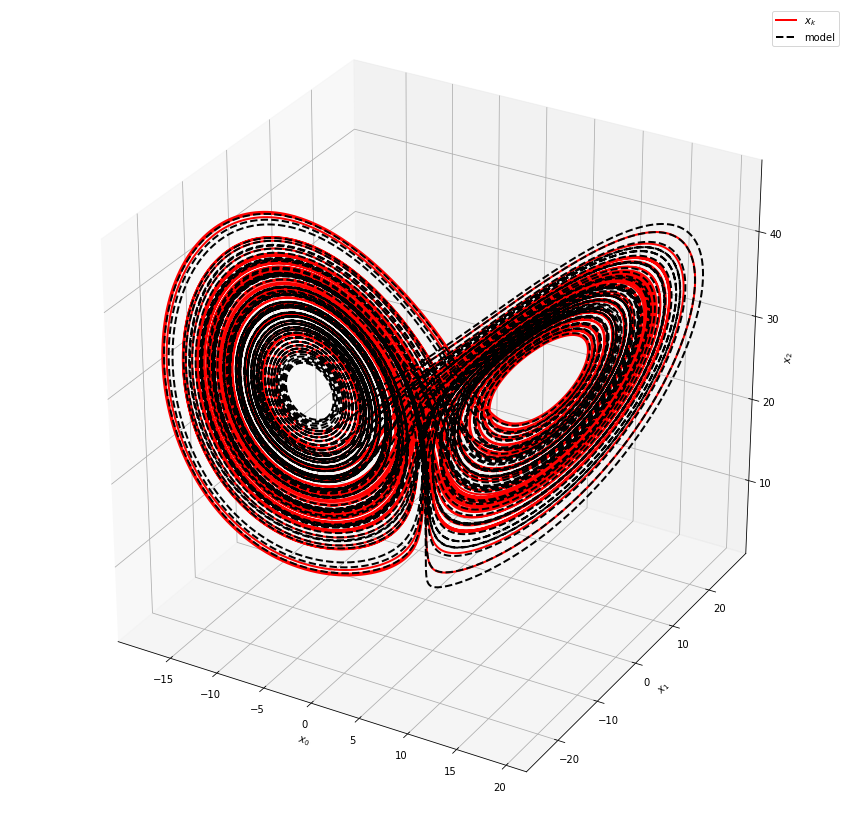

In [67]:
### adding noise on a scale of 1e-3
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-3, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.995 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -0.002 1 + -2.667 x2 + 1.000 x0 x1


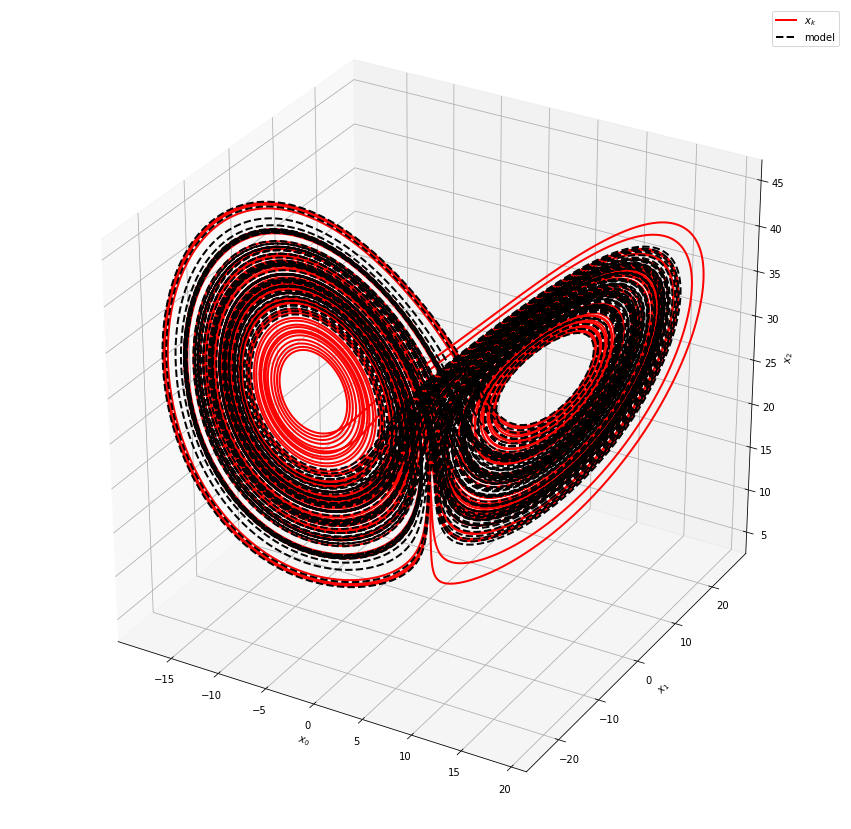

In [68]:
### adding noise on a scale of 1e-2
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-2, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 0.013 1 + -9.807 x0 + 9.889 x1 + -0.005 x0 x2 + 0.003 x1 x2
(x1)' = -0.005 1 + 27.900 x0 + -0.942 x1 + -0.997 x0 x2 + -0.002 x1 x2
(x2)' = -0.081 1 + -2.662 x2 + 0.998 x0 x1 + 0.001 x1^2


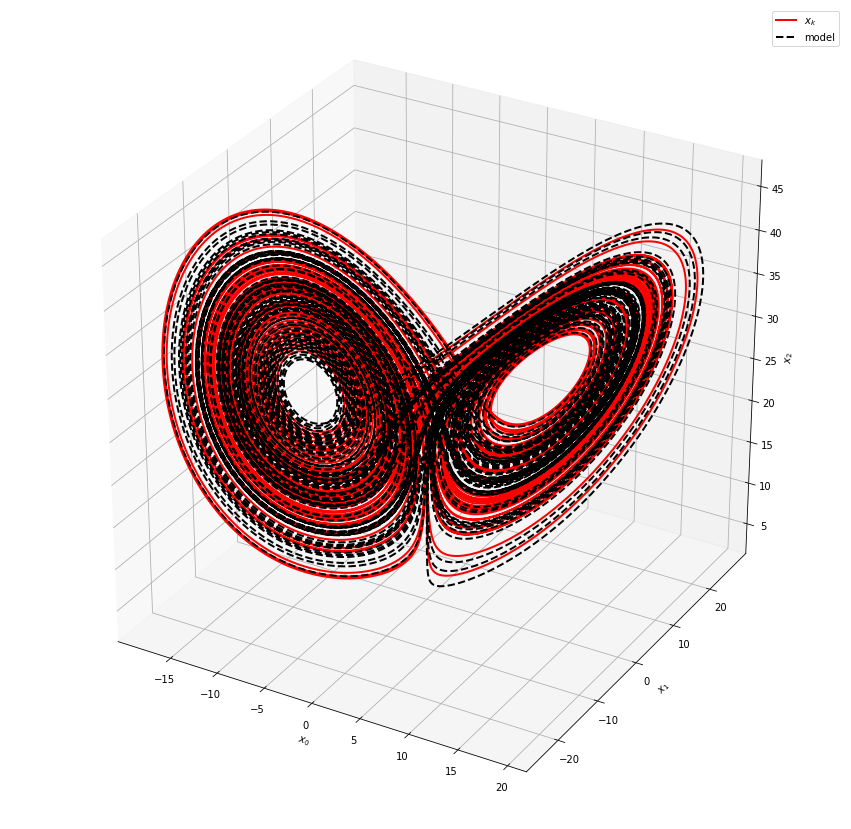

In [69]:
### adding noise on a scale of 1e-1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-1, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 9.853 1 + 1.329 x0 + 3.374 x1 + -1.215 x2 + -0.232 x0^2 + 0.240 x0 x1 + -0.286 x0 x2 + -0.063 x1^2 + 0.148 x1 x2 + 0.039 x2^2
(x1)' = 12.023 1 + 22.519 x0 + 2.112 x1 + -1.533 x2 + -0.269 x0^2 + 0.243 x0 x1 + -0.842 x0 x2 + -0.053 x1^2 + -0.087 x1 x2 + 0.048 x2^2
(x2)' = 3.698 1 + -0.306 x0 + 0.139 x1 + -3.440 x2 + -0.086 x0^2 + 0.902 x0 x1 + 0.006 x0 x2 + 0.097 x1^2 + -0.001 x1 x2 + 0.029 x2^2


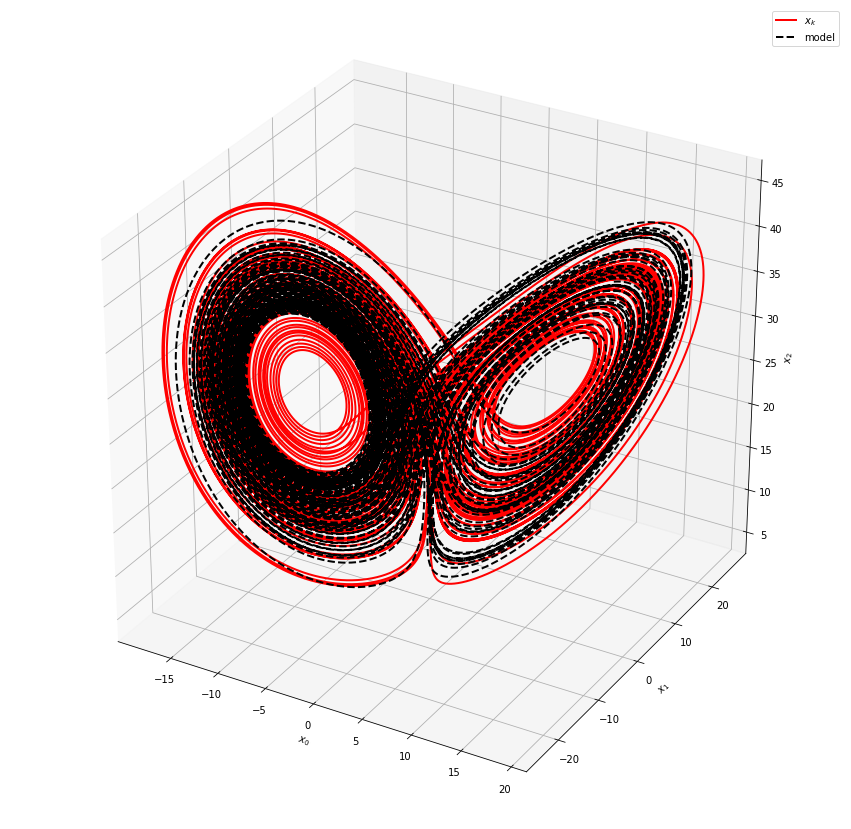

In [70]:
### adding noise on a scale of 1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-0, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 0.323 1 + 0.628 x0 + -3.852 x1 + -0.383 x2 + 0.053 x0^2 + -0.132 x0 x1 + -0.054 x0 x2 + 0.149 x1^2 + 0.219 x1 x2 + -0.024 x2^2
(x1)' = -70.349 1 + 4.489 x0 + -0.664 x1 + 5.793 x2 + -0.074 x0^2 + -0.097 x0 x1 + -0.232 x0 x2 + 0.106 x1^2 + 0.056 x1 x2 + -0.093 x2^2
(x2)' = -1.694 1 + 3.258 x0 + -4.569 x1 + -3.384 x2 + 0.159 x0^2 + -0.162 x0 x1 + -0.036 x0 x2 + 0.090 x1^2 + 0.105 x1 x2 + 0.068 x2^2


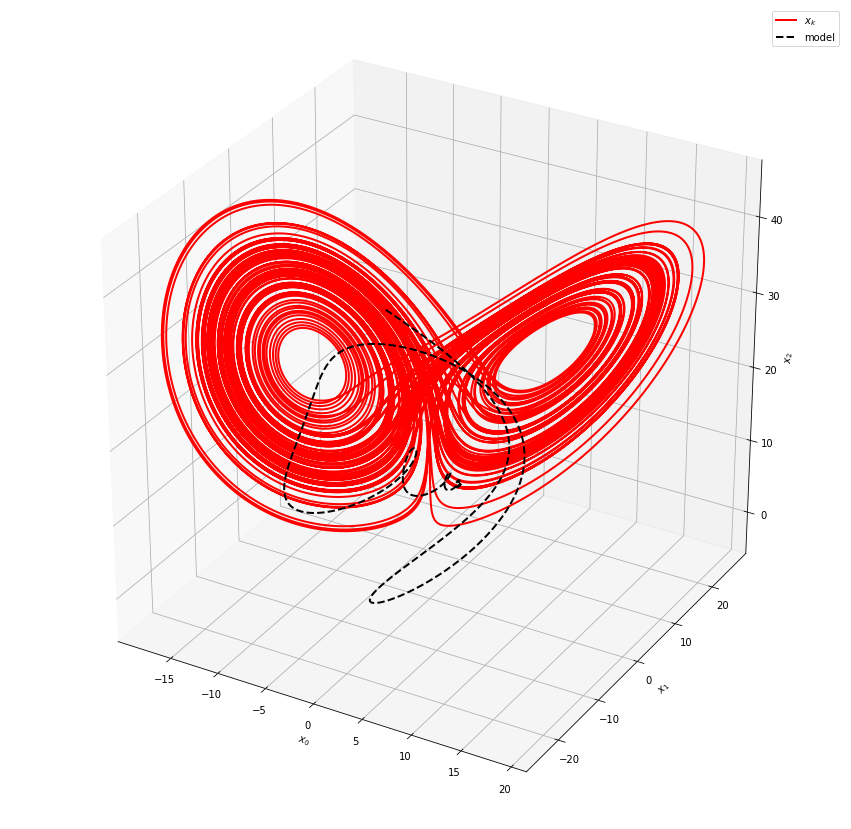

In [71]:
### adding noise on a scale of 1e1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e1, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()